In [1]:
import numpy as np
import pandas as pd
import regex as re
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report

from sklearn.utils import class_weight
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from xgboost import plot_importance


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rkroc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rkroc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('clean_data.csv')

In [3]:
data.isnull().sum() # number of nulls in the data

tweet        134
target         0
hashtag    40728
name       29594
url        43391
emoji      47252
dtype: int64

In [4]:
data = data.fillna('') # filling the null value with an empty text

# converting the target column into binary format

In [5]:
data.loc[data['target']!='not_cyberbullying','target']=1
data.loc[data['target']=='not_cyberbullying','target']=0
data['target'] = data['target'].astype('int')

In [6]:
data['target'].value_counts(normalize=1)*100 #data is not balanced

1    83.341022
0    16.658978
Name: target, dtype: float64

In [7]:
# getting the length for each of the hashtag name url and emoji column
for col in ['hashtag','name','url','emoji']:
    data[col+"_len"] = data[col].apply(lambda x:len(x))
#adding some preprocessing to clean some faetures(hashtag,name,url,emoji)
for col in ['hashtag','name','url','emoji']:
    data[col] = data[col].apply(lambda x:re.sub(r"[,']",'',x))
for col in ['hashtag','name','url','emoji']:
    data[col] = data[col].str.replace("[",'')
    data[col] = data[col].str.replace("]",'')
    if col =='emoji':
        data[col] = data[col].str.replace("_",' ')

<ipython-input-7-6f15a4babad8>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace("[",'')
<ipython-input-7-6f15a4babad8>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace("]",'')


# Removing the stop words

In [8]:
stop_words = stopwords.words('english')
stop_words.extend(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's','etc'])
text_col = data.loc[:,data.dtypes=='object'].columns
for col in text_col:
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    print("Done! {}".format(col))
data.head()

Done! tweet
Done! hashtag
Done! name
Done! url
Done! emoji


,tweet,target,hashtag,name,url,emoji,hashtag_len,name_len,url_len,emoji_len
0,words food crapilicious,0,katandandre,,,,22,0,0,0
1,white studio,0,aussietv theblock imacelebrityau today sunrise...,,,,119,0,0,0
2,classy whore red velvet cupcakes,0,,xochitlsuckkks,,,0,18,0,0
3,meh p thanks heads concerned another angry dud...,0,,jasongio,,,0,12,0,0
4,isis account pretending kurdish account like i...,0,,rudhoeenglish,,,0,17,0,0


In [9]:
def data_formation(vectoriser_type='VT'):
    if vectoriser_type=='count_vectoriser':
        cv_t = CountVectorizer(max_features = 1500,ngram_range=(1,3))
        cv_h = CountVectorizer(max_features = 500,ngram_range=(1,1))
        cv_e = CountVectorizer(max_features = 500,ngram_range=(1,1))
    else:
        cv_t = TfidfVectorizer(max_features = 1500,ngram_range=(1,3))
        cv_h = TfidfVectorizer(max_features = 500,ngram_range=(1,1))
        cv_e = TfidfVectorizer(max_features = 500,ngram_range=(1,1))
        
    
    t_array = cv_t.fit_transform(data['tweet']).toarray()
    e_array = cv_e.fit_transform(data['emoji']).toarray()
    h_array = cv_h.fit_transform(data['hashtag']).toarray()
    
    extra = data[['hashtag_len','name_len','url_len','emoji_len']].values
    extra = np.asarray(extra)
    
    X = np.hstack((t_array,h_array,e_array,extra))
    y = data['target'].values
    print(X.shape,y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

# Rishi now move to HPT blocks and delete this cell

# using the Count vectorizer 

In [10]:
X_train, X_test, y_train, y_test = data_formation(vectoriser_type='count_vectoriser')

(47692, 2214) (47692,)


In [11]:
#Decision tree Classifier on count vectoriser
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
pred= clf.predict(X_test)
acc = f1_score(pred,y_test,average='micro')
print("F1-score",acc)
print(classification_report(y_test,pred))

F1-score 0.8200020966558339
              precision    recall  f1-score   support

           0       0.46      0.51      0.48      1572
           1       0.90      0.88      0.89      7967

    accuracy                           0.82      9539
   macro avg       0.68      0.70      0.69      9539
weighted avg       0.83      0.82      0.82      9539



In [12]:
#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1)
clf.fit(X_train,y_train)
pred_rf = clf.predict(X_test)
f1_score(y_test,pred_rf,average='micro')

0.8501939406646399

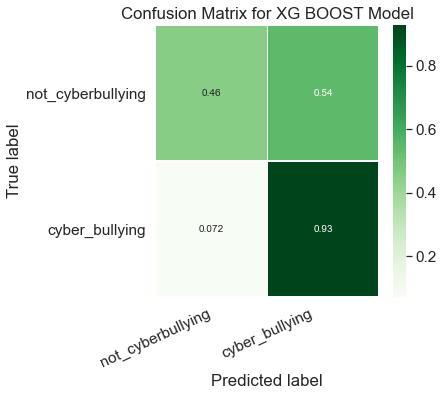

In [13]:
matrix = confusion_matrix(y_test, pred_rf)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(5,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['not_cyberbullying','cyber_bullying']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG BOOST Model')
plt.show()

In [15]:
#balanced random forest classifier
model_rb1 = BalancedRandomForestClassifier(n_estimators=100) # performs random under sampling of majority class in each sample
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_rb1, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1,verbose=3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:  4.8min remaining:   44.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.9min finished


0.79 accuracy with a standard deviation of 0.01


In [ ]:
#Extra Tree classifier
clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
f1_score(pred,y_test,average='micro')

In [ ]:
#xgboost classifier
model_xgb = XGBClassifier(objective='binary:logistic',eval_metric='logloss')
eval_set = [(X_train, y_train),(X_test,y_test)]
model_xgb.fit(X_train, y_train, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False)
pred_xgb = model_xgb.predict(X_test) #Evaluating on the test data
print(f1_score(y_test,pred_xgb_b,average='micro'))

In [ ]:
print(classification_report(y_test,pred_xgb))

In [ ]:
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
#plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
#plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#light gbm classifier
lgb_class = lgb.LGBMClassifier(n_estimators=100)
lgb_class.fit(X_train,y_train)
lgb_pred = lgb_class.predict(X_test)
f1_score(y_test,lgb_pred,average='micro')

# using TF-IDF classifier

In [12]:
X_train, X_test, y_train, y_test = data_formation(vectoriser_type='tf_idf')

(47692, 2214) (47692,)


In [ ]:
#Decision tree Classifier on count vectoriser
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
pred= clf.predict(X_test)
acc = f1_score(pred,y_test,average='micro')
print("F1-score",acc)
print(classification_report(y_test,pred))

In [ ]:
#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100,random_state=1,n_jobs=-1)
clf.fit(X_train,y_train)
pred_rf = clf.predict(X_test)
f1_score(y_test,pred_rf,average='micro')

In [ ]:
matrix = confusion_matrix(y_test, pred_rf)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(5,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['not_cyberbullying','cyber_bullying']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG BOOST Model')
plt.show()

In [ ]:
#balanced random forest classifier
model_rb1 = BalancedRandomForestClassifier(n_estimators=100) # performs random under sampling of majority class in each sample
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_rb1, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1,verbose=3)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
#Extra Tree classifier
clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
f1_score(pred,y_test,average='micro')

In [ ]:
#xgboost classifier
model_xgb = XGBClassifier(objective='binary:logistic',eval_metric='logloss')
eval_set = [(X_train, y_train),(X_test,y_test)]
model_xgb.fit(X_train, y_train, eval_metric=["error","logloss"], eval_set=eval_set, verbose=False)
pred_xgb = model_xgb.predict(X_test) #Evaluating on the test data
print(f1_score(y_test,pred_xgb_b,average='micro'))
print(classification_report(y_test,pred_xgb))

In [ ]:
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
#plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
#plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#light gbm classifier
lgb_class = lgb.LGBMClassifier(n_estimators=100)
lgb_class.fit(X_train,y_train)
lgb_pred = lgb_class.predict(X_test)
f1_score(y_test,lgb_pred,average='micro')

# Hyper parametertuning for DT 

In [ ]:
X_train, X_test, y_train, y_test = data_formation(vectoriser_type='tf_idf')

In [ ]:
pgrid = {"max_depth": [3,4,5,6,7],
      "min_samples_split": [5,10,15,20],
        "class_weight":[None,"balanced"]}
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=pgrid, scoring='f1_micro', cv=3,verbose=3)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_.score(X_test, y_test))

# Hyper paramter tunng for Random Forest

In [ ]:
#max_features=0.2
pgrid = {"max_features": [0.2, 0.4, 0.8],
        "n_estimators":[100,150,200],
        "class_weight":['balanced', None]}
clf =RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid=pgrid, scoring='f1_micro', cv=3,verbose=3)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_.score(X_test, y_test))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


# Hyper paramter tuning for LGB

In [ ]:
pgrid = {"max_samples":[i/10 for i in range(1,11,3)],
       "max_features":[i/10 for i in range(1,11,4)],
       "n_estimators":[100,150,200],
        "learning_rate":[0.01,0.05,0.1],
         "reg_lambda" = [i/10.0 for i in range(0,11,3)]}
clf =lgb.LGBMClassifier(objective='multiclass',metric='multi_logloss')
grid_search = GridSearchCV(clf, param_grid=pgrid, scoring='f1_micro', cv=10,verbose=3)
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_.score(X_test, y_test))